In [1]:
import sys
sys.path.append('/Users/tim/Desktop/Speech/lab1')
sys.path.append('/Users/tim/Desktop/Speech/lab2')
import numpy as np
from matplotlib import pyplot as plt
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


from lab3_tools import *
from lab3_proto import *

In [2]:
# phoneHMMs is a dictionary with 21 keys, each corresponding to a phonetic model
phoneHMMs = np.load('../lab2/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
# A list of unique states for reference
# Note that we model three segments for each phoneme
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(len(stateList))
stateList[39]

61


'sil_0'

# Forced Alignment

In [3]:
# Read the audio and compute liftered MFCC features
from lab1_proto import mfcc

filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

In [4]:
# Recover the sequence of digits (word level transcription) in the file
wordTrans = list(path2info(filename)[2])
wordTrans

['z', '4', '3']

In [5]:
from prondict import prondict
phoneTrans = words2phones(wordTrans, prondict)
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [6]:
from lab2_proto import concatHMMs

# Create a combined model for this specific utterance:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

In [7]:
# Map the states in utteranceHMM into the unique state names in stateList
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
print(stateTrans[8])
print(stateTrans[9])

iy_2
r_0


In [8]:
from lab2_tools import log_multivariate_normal_density_diag
from lab2_proto import viterbi

# NxM array of emission(observation) log likelihoods, N frames, M states
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars']) 
log_startprob = np.log(utteranceHMM['startprob'][:-1])
log_transmat = np.log(utteranceHMM['transmat'][:-1, :-1])
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)

print(vpath)
vpath_after_trans = [stateTrans[i] for i in vpath]
print(vpath_after_trans)

[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  3  3  3  3
  4  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  7  8  9  9
  9  9  9  9  9  9  9  9 10 11 12 13 14 14 14 14 14 14 14 14 14 16 17 17
 17 17 17 17 17 17 17 17 17 18 19 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 21 21 21 21 21 21 21 21 21 21 21 22 22 22 23 24 26 26 26 26 26 26 26
 26 26 26 27 27 27 28 29 29 29 29 29 29 29 29 29 30 31 32 32 32 32 32 32
 32 32 32 32 33 33 34 34 34 34 34 34 34 34 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36]
['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 

# Feature Extraction

In [9]:
# from lab1_proto import mspec

# traindata = []
# for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'):
#     for file in files:
#         if file.endswith('.wav'):
#             filename = os.path.join(root, file)
#             samples, samplingrate = loadAudio(filename)
#             lmfcc = mfcc(samples)
#             mspecs = mspec(samples)
#             targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
#             traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecs, 'targets': targets})
# np.savez('traindata.npz', traindata=traindata)

# testdata = []
# for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'):
#     for file in files:
#         if file.endswith('.wav'):
#             filename = os.path.join(root, file)
#             samples, samplingrate = loadAudio(filename)
#             lmfcc = mfcc(samples)
#             mspecs = mspec(samples)
#             targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
#             testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecs, 'targets': targets})
# np.savez('testdata.npz', testdata=testdata)

# Training and Validation Sets

In [10]:
train_data = np.load('traindata.npz', allow_pickle=True)['traindata']
test_data = np.load('testdata.npz', allow_pickle=True)['testdata']

In [11]:
random.seed(420)

# Include original data with parsed information
data_list = []
for item in train_data:
    filename = item['filename']
    info_tuple = path2info(filename)
    data_list.append((info_tuple, item))  # Store tuple of parsed info and the full data item

from collections import defaultdict
# Separate data by gender
gender_data = defaultdict(list)
for info, full_data in data_list:
    gender_data[info[0]].append((info, full_data))


train_set = []
valid_set = []

# Split data for each gender
for gender, items in gender_data.items():
    # Group by speaker
    speaker_data = defaultdict(list)
    for info, full_data in items:
        speaker_data[info[1]].append(full_data)
    
    # Create lists of speakers and shuffle them
    speakers = list(speaker_data.keys())
    random.shuffle(speakers)
    
    # Calculate number of speakers for training
    num_train_speakers = int(round(len(speakers) * 0.9))
    
    # Split speakers into training and validation
    train_speakers = speakers[:num_train_speakers]
    valid_speakers = speakers[num_train_speakers:]
    
    # Aggregate the data entries for each set of speakers
    for spkr in train_speakers:
        train_set.extend(speaker_data[spkr])
    for spkr in valid_speakers:
        valid_set.extend(speaker_data[spkr])

# Shuffle the sets to ensure random order
random.shuffle(train_set)
random.shuffle(valid_set)

# Acoustic Context (Dynamic Features)

In [12]:
dlmfcc_train_x = []
dmspec_train_x = []
for i in range(len(train_set)):
    current_utterance = train_set[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_train_x.append(temp_mfcc_stack)
        dmspec_train_x.append(temp_mspec_features)

dlmfcc_train_x = np.array(dlmfcc_train_x)
dmspec_train_x = np.array(dmspec_train_x) 

#---------------------------------------------------------#
dlmfcc_val_x = []
dmspec_val_x = []
for i in range(len(valid_set)):
    current_utterance = valid_set[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_val_x.append(temp_mfcc_stack)
        dmspec_val_x.append(temp_mspec_features)

dlmfcc_val_x = np.array(dlmfcc_val_x)
dmspec_val_x = np.array(dmspec_val_x) 
    
#---------------------------------------------------------#
dlmfcc_test_x = []
dmspec_test_x = []
for i in range(len(test_data)):
    current_utterance = test_data[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_test_x.append(temp_mfcc_stack)
        dmspec_test_x.append(temp_mspec_features)

dlmfcc_test_x = np.array(dlmfcc_test_x)
dmspec_test_x = np.array(dmspec_test_x) 

np.savez('dynamic_features.npz', dlmfcc_train_x=dlmfcc_train_x, dmspec_train_x=dmspec_train_x, dlmfcc_val_x=dlmfcc_val_x, dmspec_val_x=dmspec_val_x, dlmfcc_test_x=dlmfcc_test_x, dmspec_test_x=dmspec_test_x)

# Feature Standardisation

### What will happen with the very short utterances in the files containing isolated digits when normalizing each utterance individually?

Short utterances will have less reliable estimates of mean and variance, leading to potentially unstable feature scaling.

Extreme normalization values might occur if a particular feature deviates slightly in a short utterance, as there's less data to average out noise and variability. This can exaggerate the importance of minor variations in short utterances, potentially skewing the model training or performance.

In [13]:
dynamic_features = np.load('dynamic_features.npz')
dlmfcc_train_x = dynamic_features['dlmfcc_train_x']
dmspec_train_x = dynamic_features['dmspec_train_x']
dlmfcc_val_x = dynamic_features['dlmfcc_val_x']
dmspec_val_x = dynamic_features['dmspec_val_x']
dlmfcc_test_x = dynamic_features['dlmfcc_test_x']
dmspec_test_x = dynamic_features['dmspec_test_x']

In [14]:
lmfcc_train_x = []
mspec_train_x = []
train_y = []
for i in range(len(train_set)):
    lmfcc_train_x.append(train_set[i]['lmfcc'])
    mspec_train_x.append(train_set[i]['mspec'])
    train_y.append(train_set[i]['targets'])
lmfcc_train_x = np.concatenate(lmfcc_train_x, axis=0)
mspec_train_x = np.concatenate(mspec_train_x, axis=0)
train_y = np.concatenate(train_y, axis=0)
#---------------------------------------------------------#
lmfcc_val_x = []
mspec_val_x = []
val_y = []
for i in range (len(valid_set)):
    lmfcc_val_x.append(valid_set[i]['lmfcc'])
    mspec_val_x.append(valid_set[i]['mspec'])
    val_y.append(valid_set[i]['targets'])
lmfcc_val_x = np.concatenate(lmfcc_val_x, axis=0)
mspec_val_x = np.concatenate(mspec_val_x, axis=0)
val_y = np.concatenate(val_y, axis=0)
#---------------------------------------------------------#
lmfcc_test_x = []
mspec_test_x = []
test_y = []
for i in range (len(test_data)):
    lmfcc_test_x.append(test_data[i]['lmfcc'])
    mspec_test_x.append(test_data[i]['mspec'])
    test_y.append(test_data[i]['targets'])
lmfcc_test_x = np.concatenate(lmfcc_test_x, axis=0)
mspec_test_x = np.concatenate(mspec_test_x, axis=0)
test_y = np.concatenate(test_y, axis=0)

In [15]:
print(lmfcc_train_x.shape)
print(lmfcc_val_x.shape)
print(lmfcc_test_x.shape)
print()
print(mspec_train_x.shape)
print(mspec_val_x.shape)
print(mspec_test_x.shape)
print()
print(dlmfcc_train_x.shape)
print(dlmfcc_val_x.shape)
print(dlmfcc_test_x.shape)
print()
print(dmspec_train_x.shape)
print(dmspec_val_x.shape)
print(dmspec_test_x.shape)

(1363305, 13)
(144087, 13)
(1527014, 13)

(1363305, 40)
(144087, 40)
(1527014, 40)

(1363305, 91)
(144087, 91)
(1527014, 91)

(1363305, 280)
(144087, 280)
(1527014, 280)


In [16]:
from sklearn.preprocessing import StandardScaler

lmfcc_scaler = StandardScaler()
dlmfcc_scaler = StandardScaler()
mspec_scaler = StandardScaler()
dmspec_scaler = StandardScaler()

lmfcc_train_x = lmfcc_scaler.fit_transform(lmfcc_train_x)
dlmfcc_train_x = dlmfcc_scaler.fit_transform(dlmfcc_train_x)
mspec_train_x = mspec_scaler.fit_transform(mspec_train_x)
dmspec_train_x = dmspec_scaler.fit_transform(dmspec_train_x)
lmfcc_train_x = torch.tensor(lmfcc_train_x, dtype=torch.float32)
dlmfcc_train_x = torch.tensor(dlmfcc_train_x, dtype=torch.float32)
mspec_train_x = torch.tensor(mspec_train_x, dtype=torch.float32)
dmspec_train_x = torch.tensor(dmspec_train_x, dtype=torch.float32)

# Transform validation and test data using the normalization coefficients from training data
lmfcc_val_x = lmfcc_scaler.transform(lmfcc_val_x)
dlmfcc_val_x = dlmfcc_scaler.transform(dlmfcc_val_x)
mspec_val_x = mspec_scaler.transform(mspec_val_x)
dmspec_val_x = dmspec_scaler.transform(dmspec_val_x)
lmfcc_val_x = torch.tensor(lmfcc_val_x, dtype=torch.float32)
dlmfcc_val_x = torch.tensor(dlmfcc_val_x, dtype=torch.float32)
mspec_val_x = torch.tensor(mspec_val_x, dtype=torch.float32)
dmspec_val_x = torch.tensor(dmspec_val_x, dtype=torch.float32)

lmfcc_test_x = lmfcc_scaler.transform(lmfcc_test_x)
dlmfcc_test_x = dlmfcc_scaler.transform(dlmfcc_test_x)
mspec_test_x = mspec_scaler.transform(mspec_test_x)
dmspec_test_x = dmspec_scaler.transform(dmspec_test_x)
lmfcc_test_x = torch.tensor(lmfcc_test_x, dtype=torch.float32)
dlmfcc_test_x = torch.tensor(dlmfcc_test_x, dtype=torch.float32)
mspec_test_x = torch.tensor(mspec_test_x, dtype=torch.float32)
dmspec_test_x = torch.tensor(dmspec_test_x, dtype=torch.float32)

In [17]:
output_dim = len(stateList)
print(output_dim)
train_y = F.one_hot(torch.tensor(train_y), num_classes=output_dim).float()
val_y = F.one_hot(torch.tensor(val_y), num_classes=output_dim).float()
test_y = F.one_hot(torch.tensor(test_y), num_classes=output_dim).float()

61


In [18]:
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

torch.Size([1363305, 61])
torch.Size([144087, 61])
torch.Size([1527014, 61])


# Phoneme Recognition with Deep Neural Networks

In [19]:
# Define the DNN model class
class PhonemeDNN(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden_layers=0, num_units=256):
        super(PhonemeDNN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, num_units))
        self.layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(num_units, num_units))
            self.layers.append(nn.ReLU())
        
        # Output layer
        self.layers.append(nn.Linear(num_units, num_classes))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [20]:
def calculate_accuracy(outputs, labels):
    # Assuming outputs are logits and labels are one-hot encoded
    predicted = torch.argmax(outputs, dim=1)
    actual = torch.argmax(labels, dim=1)
    correct = (predicted == actual).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256, epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()  # Recommended for one-hot encoded targets

    train_accuracies = []
    val_accuracies = []

    num_samples = X_train.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            
            inputs = X_train[start_idx:end_idx]
            labels = y_train[start_idx:end_idx]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            total_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
        
        average_train_accuracy = total_accuracy / num_samples
        train_accuracies.append(average_train_accuracy)
        
        # Validation
        model.eval()
        total_val_accuracy = 0.0
        with torch.no_grad():
            num_val_samples = X_val.shape[0]
            outputs = model(X_val)
            total_val_accuracy = calculate_accuracy(outputs, y_val)
            val_accuracies.append(total_val_accuracy)

        print(f'Epoch {epoch+1}, Train Accuracy: {average_train_accuracy:.4f}, Validation Accuracy: {total_val_accuracy:.4f}')

    # Testing
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_accuracy = calculate_accuracy(outputs, y_test)
        print(f'Test Accuracy: {test_accuracy:.4f}')
    
    return train_accuracies, val_accuracies
    

In [22]:
# Hyperparameters
num_classes = len(stateList) 
batch_size=256
epochs=10
learning_rate=0.001

### 1. Input: Liftered MFCCs, 1 & 4 hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.3892, Validation Accuracy: 0.4029
Epoch 2, Train Accuracy: 0.4150, Validation Accuracy: 0.4108
Epoch 3, Train Accuracy: 0.4209, Validation Accuracy: 0.4160
Epoch 4, Train Accuracy: 0.4247, Validation Accuracy: 0.4185
Epoch 5, Train Accuracy: 0.4274, Validation Accuracy: 0.4203
Epoch 6, Train Accuracy: 0.4291, Validation Accuracy: 0.4209
Epoch 7, Train Accuracy: 0.4307, Validation Accuracy: 0.4209
Epoch 8, Train Accuracy: 0.4320, Validation Accuracy: 0.4220
Epoch 9, Train Accuracy: 0.4332, Validation Accuracy: 0.4223
Epoch 10, Train Accuracy: 0.4342, Validation Accuracy: 0.4222
Test Accuracy: 0.4212
Epoch 1, Train Accuracy: 0.3676, Validation Accuracy: 0.4037
Epoch 2, Train Accuracy: 0.4128, Validation Accuracy: 0.4116
Epoch 3, Train Accuracy: 0.4201, Validation Accuracy: 0.4151
Epoch 4, Train Accuracy: 0.4243, Validation Accuracy: 0.4171
Epoch 5, Train Accuracy: 0.4276, Validation Accuracy: 0.4184
Epoch 6, Train Accuracy: 0.4301, Validation Accuracy: 0.4191
E

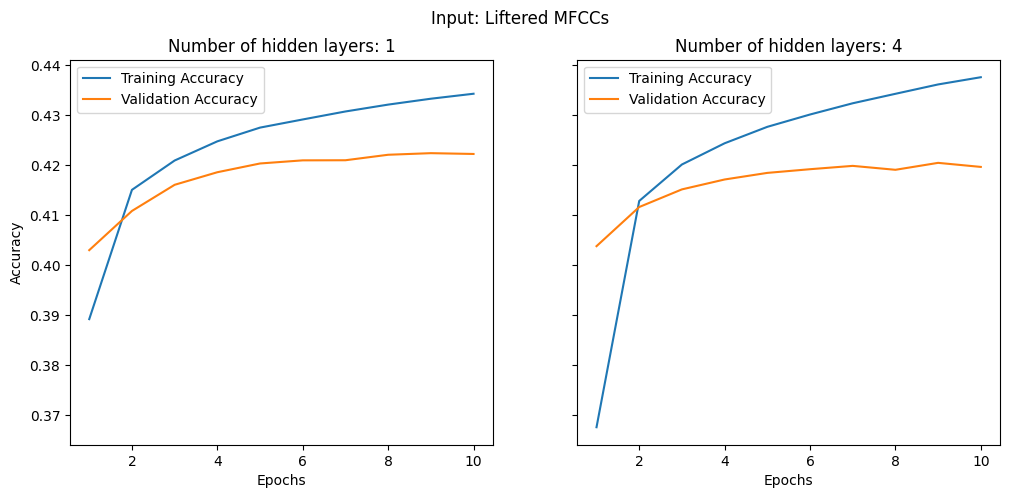

In [23]:
input_size = 13
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, lmfcc_train_x, train_y, lmfcc_val_x, val_y, lmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, lmfcc_train_x, train_y, lmfcc_val_x, val_y, lmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Liftered MFCCs')
plt.show()

### 2. Input: Filterbank features, one to four hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.3776, Validation Accuracy: 0.3975
Epoch 2, Train Accuracy: 0.4074, Validation Accuracy: 0.4058
Epoch 3, Train Accuracy: 0.4152, Validation Accuracy: 0.4115
Epoch 4, Train Accuracy: 0.4198, Validation Accuracy: 0.4152
Epoch 5, Train Accuracy: 0.4228, Validation Accuracy: 0.4162
Epoch 6, Train Accuracy: 0.4255, Validation Accuracy: 0.4179
Epoch 7, Train Accuracy: 0.4274, Validation Accuracy: 0.4195
Epoch 8, Train Accuracy: 0.4293, Validation Accuracy: 0.4202
Epoch 9, Train Accuracy: 0.4308, Validation Accuracy: 0.4200
Epoch 10, Train Accuracy: 0.4322, Validation Accuracy: 0.4215
Test Accuracy: 0.4196
Epoch 1, Train Accuracy: 0.3580, Validation Accuracy: 0.3929
Epoch 2, Train Accuracy: 0.4034, Validation Accuracy: 0.4058
Epoch 3, Train Accuracy: 0.4134, Validation Accuracy: 0.4118
Epoch 4, Train Accuracy: 0.4189, Validation Accuracy: 0.4125
Epoch 5, Train Accuracy: 0.4236, Validation Accuracy: 0.4128
Epoch 6, Train Accuracy: 0.4267, Validation Accuracy: 0.4144
E

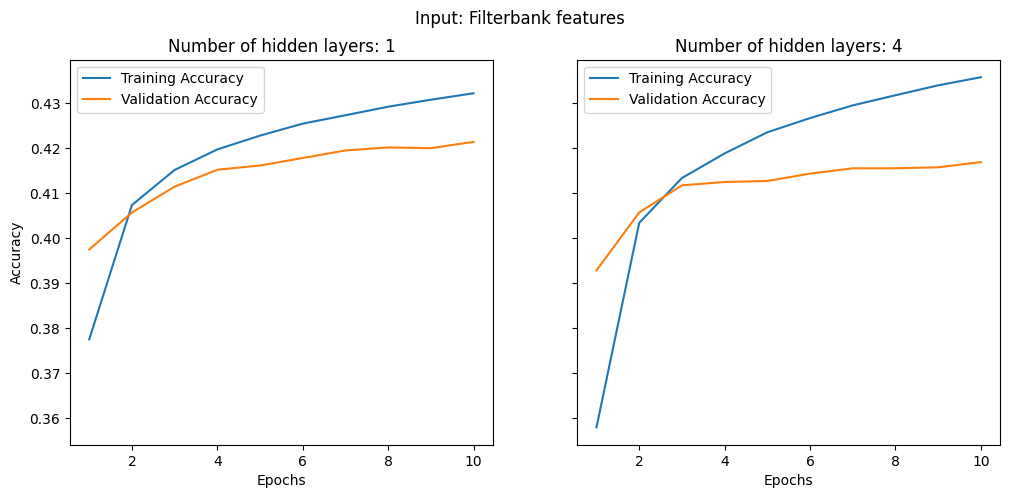

In [24]:
input_size = 40
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, mspec_train_x, train_y, mspec_val_x, val_y, mspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, mspec_train_x, train_y, mspec_val_x, val_y, mspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Filterbank features')
plt.show()

### 3. Input: Dynamic liftered MFCCs, 1 & 4 hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.4237, Validation Accuracy: 0.4484
Epoch 2, Train Accuracy: 0.4598, Validation Accuracy: 0.4624
Epoch 3, Train Accuracy: 0.4712, Validation Accuracy: 0.4693
Epoch 4, Train Accuracy: 0.4810, Validation Accuracy: 0.4745
Epoch 5, Train Accuracy: 0.4861, Validation Accuracy: 0.4773
Epoch 6, Train Accuracy: 0.4896, Validation Accuracy: 0.4775
Epoch 7, Train Accuracy: 0.4923, Validation Accuracy: 0.4788
Epoch 8, Train Accuracy: 0.4945, Validation Accuracy: 0.4788
Epoch 9, Train Accuracy: 0.4964, Validation Accuracy: 0.4785
Epoch 10, Train Accuracy: 0.4980, Validation Accuracy: 0.4790
Test Accuracy: 0.4793
Epoch 1, Train Accuracy: 0.3978, Validation Accuracy: 0.4423
Epoch 2, Train Accuracy: 0.4566, Validation Accuracy: 0.4601
Epoch 3, Train Accuracy: 0.4703, Validation Accuracy: 0.4702
Epoch 4, Train Accuracy: 0.4808, Validation Accuracy: 0.4739
Epoch 5, Train Accuracy: 0.4863, Validation Accuracy: 0.4771
Epoch 6, Train Accuracy: 0.4903, Validation Accuracy: 0.4769
E

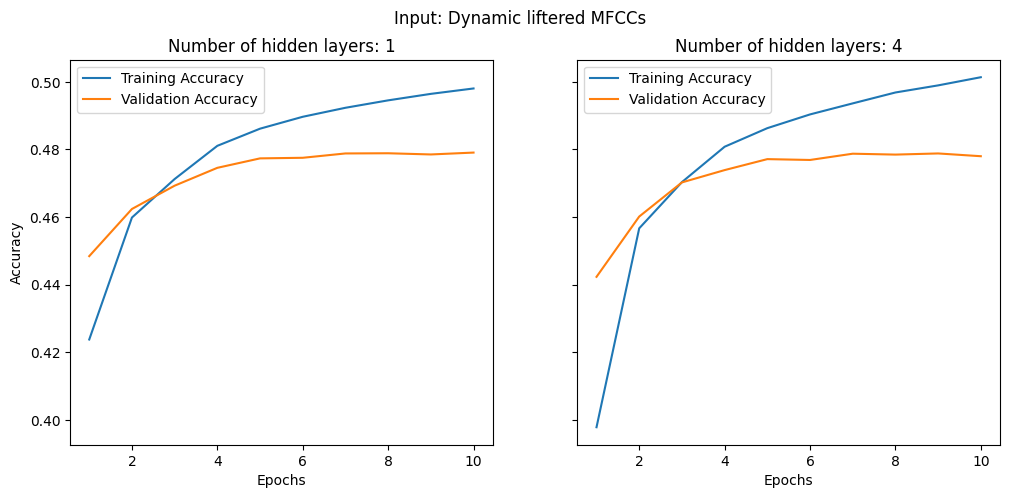

In [25]:
input_size = 91
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, dlmfcc_train_x, train_y, dlmfcc_val_x, val_y, dlmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, dlmfcc_train_x, train_y, dlmfcc_val_x, val_y, dlmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Dynamic liftered MFCCs')
plt.show()

### 4. Input: Dynamic filterbank features, one to four hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.4139, Validation Accuracy: 0.4359
Epoch 2, Train Accuracy: 0.4518, Validation Accuracy: 0.4491
Epoch 3, Train Accuracy: 0.4618, Validation Accuracy: 0.4528
Epoch 4, Train Accuracy: 0.4675, Validation Accuracy: 0.4630
Epoch 5, Train Accuracy: 0.4720, Validation Accuracy: 0.4630
Epoch 6, Train Accuracy: 0.4748, Validation Accuracy: 0.4647
Epoch 7, Train Accuracy: 0.4773, Validation Accuracy: 0.4673
Epoch 8, Train Accuracy: 0.4792, Validation Accuracy: 0.4678
Epoch 9, Train Accuracy: 0.4813, Validation Accuracy: 0.4682
Epoch 10, Train Accuracy: 0.4829, Validation Accuracy: 0.4681
Test Accuracy: 0.4671
Epoch 1, Train Accuracy: 0.3921, Validation Accuracy: 0.4203
Epoch 2, Train Accuracy: 0.4479, Validation Accuracy: 0.4531
Epoch 3, Train Accuracy: 0.4601, Validation Accuracy: 0.4604
Epoch 4, Train Accuracy: 0.4681, Validation Accuracy: 0.4639
Epoch 5, Train Accuracy: 0.4729, Validation Accuracy: 0.4658
Epoch 6, Train Accuracy: 0.4771, Validation Accuracy: 0.4672
E

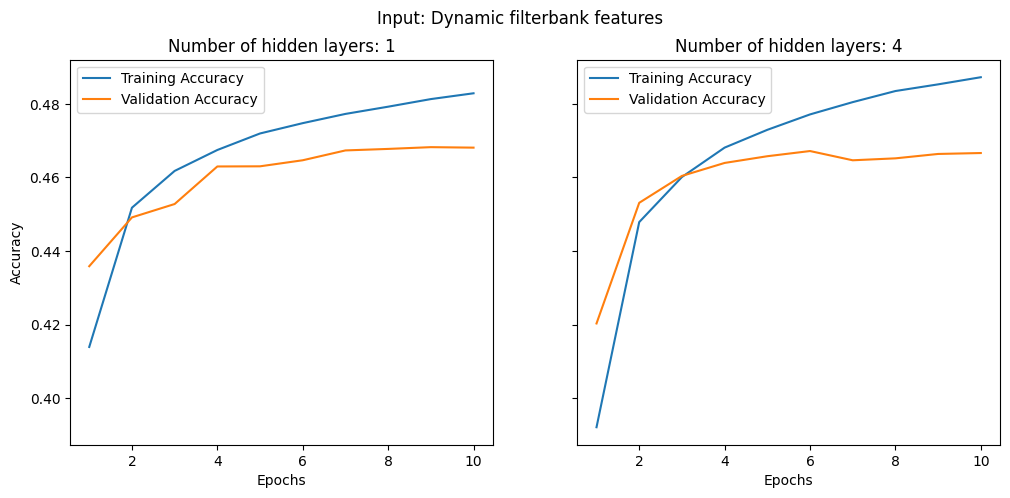

In [26]:
input_size = 280
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, dmspec_train_x, train_y, dmspec_val_x, val_y, dmspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, dmspec_train_x, train_y, dmspec_val_x, val_y, dmspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Dynamic filterbank features')
plt.show()

# Detailed Evaluation

According to the experiments above, I decide to test dynamic liftered MFCCs input with 1 hidden layers of size 256, rectified linear units.

In [27]:
input_size = 91
epochs = 10
model = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)

train_accuracies, val_accuracies = train_model(model, dlmfcc_train_x, train_y, dlmfcc_val_x, val_y, dlmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)

model.eval()  # Set model to evaluation mode
outputs = model(dlmfcc_test_x)
posteriors = torch.softmax(outputs, dim=1).detach().numpy()

Epoch 1, Train Accuracy: 0.4245, Validation Accuracy: 0.4463
Epoch 2, Train Accuracy: 0.4604, Validation Accuracy: 0.4603
Epoch 3, Train Accuracy: 0.4708, Validation Accuracy: 0.4660
Epoch 4, Train Accuracy: 0.4785, Validation Accuracy: 0.4751
Epoch 5, Train Accuracy: 0.4856, Validation Accuracy: 0.4768
Epoch 6, Train Accuracy: 0.4894, Validation Accuracy: 0.4779
Epoch 7, Train Accuracy: 0.4923, Validation Accuracy: 0.4794
Epoch 8, Train Accuracy: 0.4944, Validation Accuracy: 0.4800
Epoch 9, Train Accuracy: 0.4962, Validation Accuracy: 0.4816
Epoch 10, Train Accuracy: 0.4982, Validation Accuracy: 0.4818
Test Accuracy: 0.4806


### Frame-by-frame accuracy and confusion matrix at the state level:

State-level Accuracy: 
0.48059284328761886



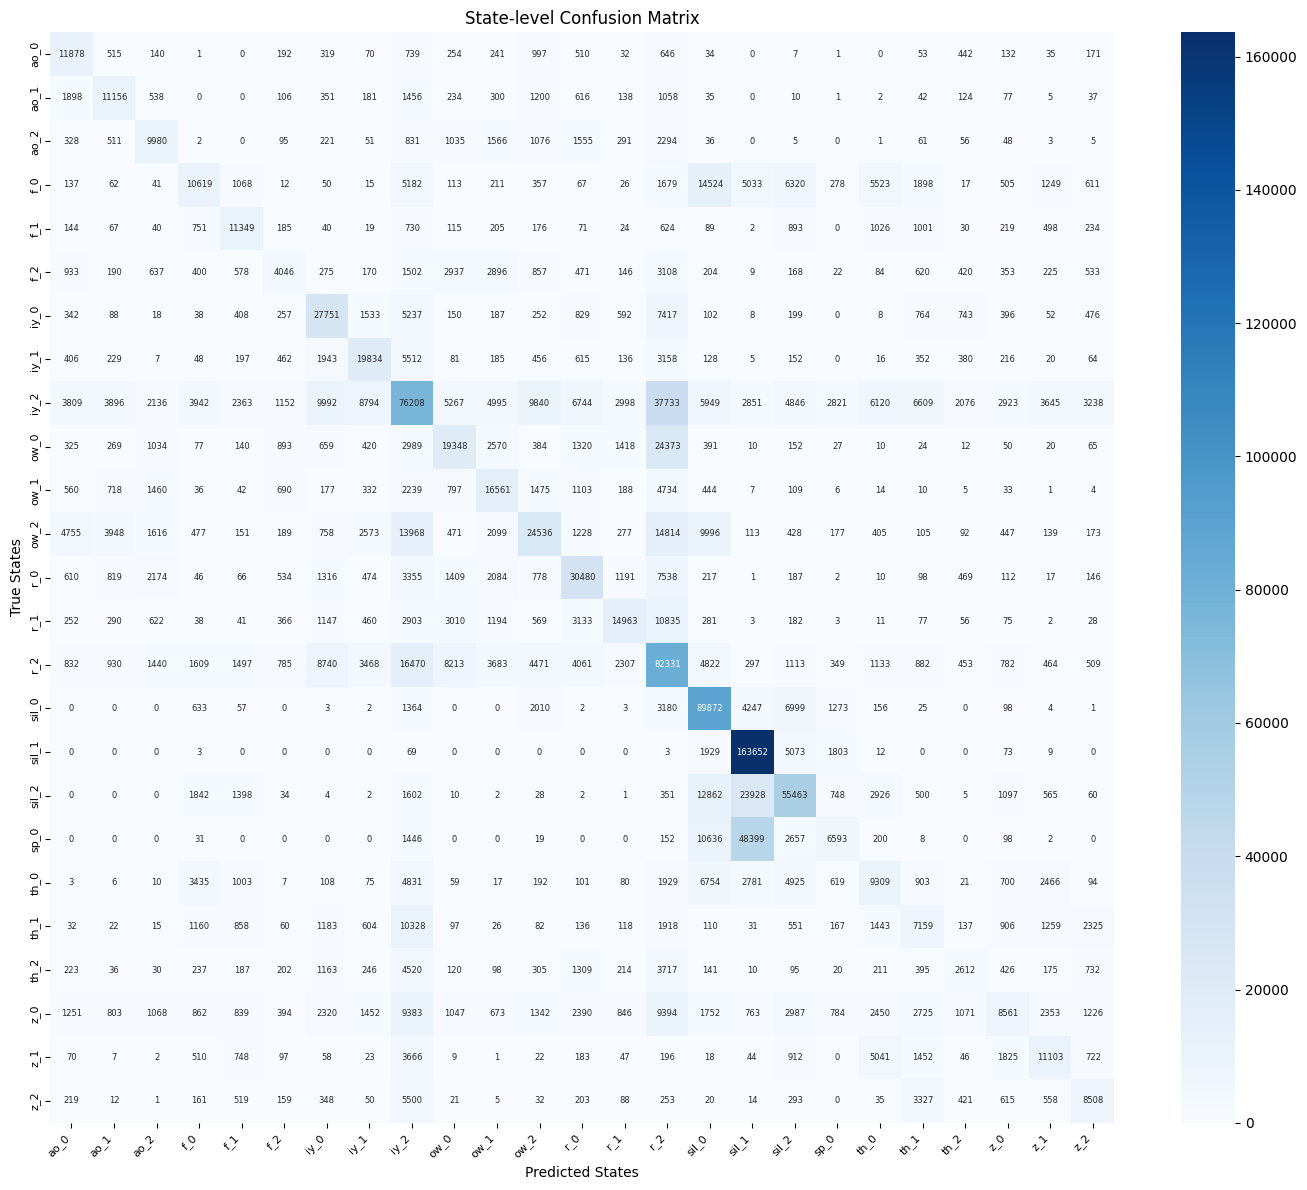

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix

predicted_indices = torch.argmax(outputs, dim=1).tolist()
true_indices = torch.argmax(test_y, dim=1).tolist()
state_level_accuracy = accuracy_score(true_indices, predicted_indices)
print(f"State-level Accuracy: \n{state_level_accuracy}\n")

all_unique_state_indices = sorted(set(predicted_indices + true_indices))
all_unique_states = [stateList[idx] for idx in all_unique_state_indices]
state_level_cm = confusion_matrix(true_indices, predicted_indices, labels=all_unique_state_indices)

# Plot the confusion matrix
plt.figure(figsize=(14, 12))
ax = sns.heatmap(state_level_cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=all_unique_states, yticklabels=all_unique_states, annot_kws={"size": 6})
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Predicted States', fontsize=10)
plt.ylabel('True States', fontsize=10)
plt.title('State-level Confusion Matrix', fontsize=12)
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()

### Frame-by-frame accuracy and confusion matrix at the phoneme level

Phoneme-level Accuracy: 
0.5737439211428317



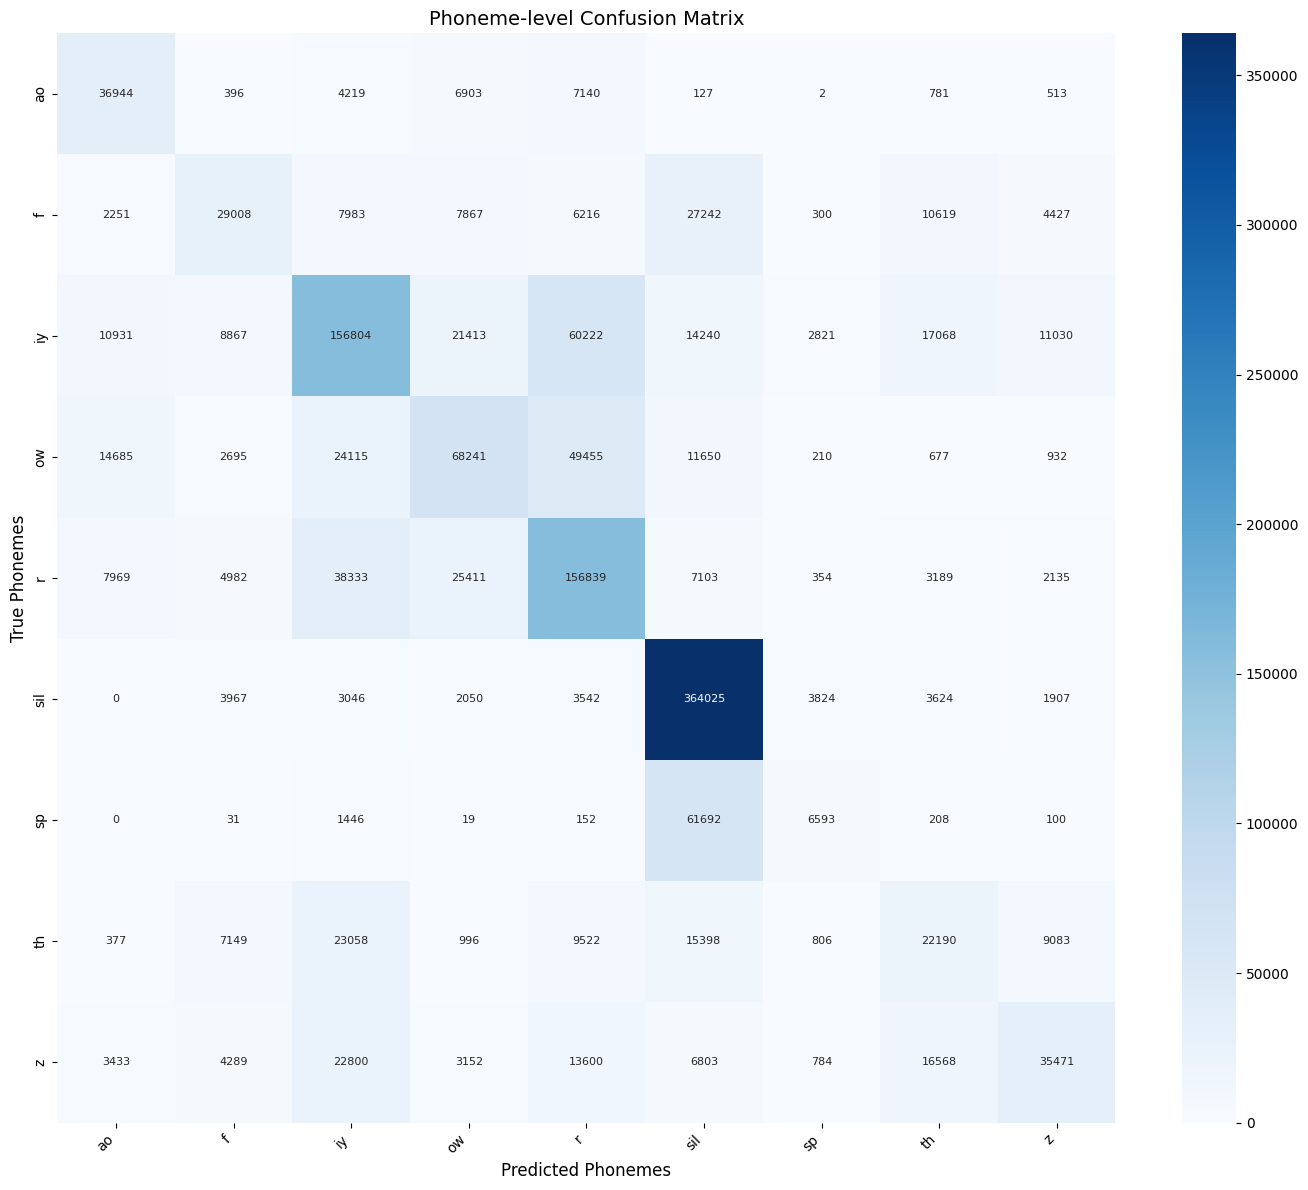

In [29]:
def state_to_phoneme(state_index):
    state_name = stateList[state_index]
    phoneme_index = phones.index(state_name.split('_')[0])
    return phoneme_index


phoneme_predictions = [state_to_phoneme(pred) for pred in predicted_indices]
phoneme_targets = [state_to_phoneme(true) for true in true_indices]
phoneme_level_accuracy = accuracy_score(phoneme_targets, phoneme_predictions)
print(f"Phoneme-level Accuracy: \n{phoneme_level_accuracy}\n")


all_unique_phoneme_indices = sorted(set(phoneme_predictions + phoneme_targets))
all_unique_phoneme = [phones[idx] for idx in all_unique_phoneme_indices]
phone_level_cm = confusion_matrix(phoneme_targets, phoneme_predictions, labels=all_unique_phoneme_indices)

# Plot the confusion matrix
plt.figure(figsize=(14, 12))
ax = sns.heatmap(phone_level_cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=all_unique_phoneme, yticklabels=all_unique_phoneme, annot_kws={"size": 8})
plt.xticks(rotation=45, ha="right", fontsize=10) 
plt.yticks(fontsize=10) 
plt.xlabel('Predicted Phonemes', fontsize=12)
plt.ylabel('True Phonemes', fontsize=12)
plt.title('Phoneme-level Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

### Edit distance at the state & phoneme level

In [31]:
from itertools import groupby
from fastdtw import fastdtw

def merge_sequences(seq):
    return [s for s, _ in groupby(seq)]

merged_pred_states = merge_sequences(predicted_indices)
merged_true_states = merge_sequences(true_indices)

# To evaluate the performance of speech recognition systems
# By comparing the predicted sequence to the true sequence using the Dynamic Time Warping (DTW) algorithm
distance, _ = fastdtw(merged_pred_states, merged_true_states)
state_per = distance / len(merged_true_states)

merged_pred_phonemes = merge_sequences(phoneme_predictions)
merged_true_phonemes = merge_sequences(phoneme_targets)

distance_phoneme, _ = fastdtw(merged_pred_phonemes, merged_true_phonemes)
phoneme_per = distance_phoneme / len(merged_true_phonemes)

print(f"State-level PER: {state_per}")
print(f"Phoneme-level PER: {phoneme_per}")

State-level PER: 19.02454500056652
Phoneme-level PER: 10.988057452668238


In [ ]:
# print(posteriors.shape)

# example_index = 0
# probabilities = posteriors[example_index]  # It's already a numpy array

# # Reshape the data to make it 2D: here, it can be (61, 1) to create a single column heatmap
# probabilities = probabilities.reshape(-1, 1)

# plt.figure(figsize=(10, 4))
# plt.imshow(probabilities, aspect='auto', origin='lower', cmap='viridis') 
# plt.title('Posterior Probabilities for Example Utterance')
# plt.xlabel('Class Index')
# plt.ylabel('Frame Index')

# # Since there's only one 'frame', we may adjust the y-axis to show class labels if required
# plt.yticks(range(len(probabilities)), range(1, 62))  # Adjust ticks to class indices if needed

# plt.show()

# Possible questions

### What is the influence of feature kind and size of input context window?
The model performance. 

The context window size determines how much of the temporal information surrounding each frame is considered by the network. A larger window provides more contextual information, potentially improving recognition accuracy but also increasing the complexity of the model. Dynamic features, which include several frames of context, typically lead to better performance compared to static features.

### What is the purpose of normalising (standardising) the input feature vectors depending on the activation functions in the network?
Normalising the feature vectors ensures that each feature contributes equally to the learning process, preventing features with larger numerical ranges from dominating the training dynamics. 

This is crucial when using activation functions like sigmoid or tanh in the network, as these functions are sensitive to input scale and can suffer from saturation issues: inputs with large absolute values cause the function outputs to be near the function's asymptotes, resulting in gradients close to zero.

### What is the influence of the number of units per layer and the number of layers?
Increasing the number of units per layer typically allows the network to learn more complex patterns and representations, improving its capability to differentiate between more subtle features of the input. 

Similarly, more layers can enable deeper (hence, potentially more abstract) feature learning. 

However, larger and deeper networks are more prone to overfitting and require more data and computational resources to train effectively.

### What is the influence of the activation function (when you try other activation functions than ReLU, you do not need to reach convergence in case you do not have enough time)
The choice of activation function affects the training dynamics and the performance of the network. 

ReLU (Rectified Linear Unit) is commonly used because it helps in alleviating the vanishing gradient problem encountered with sigmoid or tanh functions. 

### What is the influence of the learning rate/learning rate strategy?
Too high a rate can cause the training to diverge, while too low a rate might result in a painfully slow convergence or getting stuck in local minima. 

Adaptive learning rate strategies like Adam adjust the learning rate during training, which can lead to faster convergence and can alleviate some of the tuning requirements.

### How stable are the posteriograms from the network in time?
Posteriors produced by the network should ideally be stable for consistent phonetic units across similar contexts. 

However, in practice, stability can vary depending on factors like network architecture, training sufficiency, and the inherent variability of speech.

### How do the errors distribute depending on phonetic class?
Some phonemes might be consistently harder to recognize due to their acoustic similarity to other phonemes, less distinctiveness in their spectral features, or their shorter duration. 

Confusion matrices by phonetic class can help identify which phonemes are most frequently misclassified and which phonemes they are confused with.
